# DTSA5509 Supervised Learning  
## Final Project: Image Classifier for Faces Wearing Sunglasses (Deliverable #1)
### Matt Schurmann
**masc3796@colorado.edu**<br>
**Updated: Nov 22 2023**<br>

### 1.) PROJECT TOPIC


#### Type of Learning: Supervised Learning
#### Type of Problem: Classification

The main focus of this project is to create an image classifier to determine whether or not the person in the image is wearing sunglasses. Multile models and hyperparameters are analyzed. Two example images from the data set are shown below. 

*Sunglasses OFF*&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Sunglasses ON*<br>
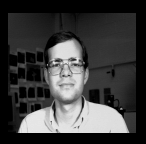 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   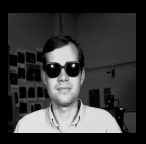    

The python modules used in this project are imported below for code clarity. 



## 2.) Data Set

#### a.) Description:
The data set contains greyscale images of various faces, labeled with attributes to indicate (1) the direction the face is looking, (2) the facial expression, and (3) whether or not the user is wearing sunglasses. 

#### b.) Data Set citation:
Mitchell,Tom. (1999). CMU Face Images. UCI Machine Learning Repository. https://doi.org/10.24432/C5JC79. <br>

#### c.) Data Summary:
**Number of Images:** 640 <br>
**File Format:** Portable Greyscale Map (.pgm)<br>
**Color Palette:** Greyscale <br>
**Dimensions:** 3 <u>copies</u> of each image, (120x128), (60x64), (30x32)<br>
**Modalities:** <br>
&nbsp;&nbsp;&nbsp;Direction - Left, Right, Up, Straight<br>
&nbsp;&nbsp;&nbsp;Mood - Happy, Sad, Angry, Neutral<br>
&nbsp;&nbsp;&nbsp;Sunglasses - On, Off<br>


### 3.) Data Cleaning

#### a.) Data cleaning issues to be resolved
 - Some of the images are mis-captures, do not have clear images of faces. These have file extensions ".bad" instead of ".pgm"
 - Data labels are encoded in the file names of each image and not in any tabular format
 - Each image is duplicated 3 times in different resolutions. I have selected only the highest resolution versions for this project.
 - Some label classes are not binary (e.g. more than 2 labels). Need to split these into multiple binary labels so that each can take a binary value. For example, "mood" can take values (happy, sad, angry, neutral). These will be split into binary labels (mood_happy, mood_sad, mood_angry, mood_neutral) which have values (1 or 0).
 - Image files need to be converted to numpy arrays for processing in sklearn models.

**Examples**

Bad image (reject) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Full Resolution (keep) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1/2 resolution (reject) &nbsp;&nbsp;&nbsp;&nbsp; 1/4 resolution (reject) <br/>
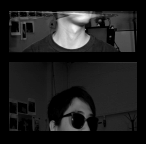 &nbsp; 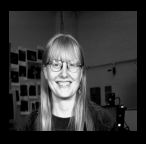 &nbsp; 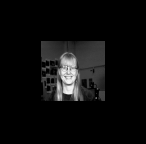 &nbsp; 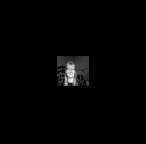 <br/>

#### b.) Data cleaning procedure/actions taken
To clean the data properly, I have used written a python script below to:
- Loop through the image folder recursively
- Parse the labels for each file from the file name
- Reject unwanted data points (e.g. ".bad") file extensions, and low-resolution images (labeled "_2" and "_4").
- Creates binary-class versions of each label where needed
- Create a ".csv" file, which can be imported with pandas, to match files with labels

The result of the first cell is the file "data_index.csv" which is a table with the following headers: "path",
"username", "direction", "mood", "sunglasses", "direction_left", "direction_right", "direction_straight", "direction_up", "mood_angry",  "mood_happy", "mood_neutral", "mood_sad", "sunglasses_on"

In [86]:
#imports used in the whole notebook are listed in this cell
import os
import csv
import pickle
import skimage
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import random
import seaborn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from timeit import default_timer as timer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import Normalize
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from IPython.display import display, HTML




In [9]:
# Create the data index csv file

rootpath = "/home/matt/Documents/MSEE/DTSA5509_Machine_Learning_I_Supervised_Learning/Final_Project/"

with open(rootpath + "data_index.csv", "w") as f:
    w = csv.writer(f, delimiter=",")

    #header row
    w.writerow([ "path", "username", "direction", "mood", "sunglasses", "direction_left", "direction_right", "direction_straight",
        "direction_up", "mood_angry","mood_happy", "mood_neutral", "mood_sad", "sunglasses_on" ])

    #loop recursively through the image directory
    for root, dirs, files in os.walk(rootpath+"faces/", topdown=False):
        for name in files:
            fname = os.path.join(root, name)

            #these conditions reject bad and low-resolution images
            if (not "_2" in fname) and (not "_4" in fname) and (".pgm" in fname):
            
                sp = fname.split("/")[-1].split("_")
                
                w.writerow([
                    fname,           #path
                    sp[0],       #username
                    sp[1],                          #direction
                    sp[2],                          #mood
                    sp[3][:-4],                     #sunglasses
                    str(int(sp[1] == "left")),
                    str(int(sp[1] == "right")),  
                    str(int(sp[1] == "straight")),
                    str(int(sp[1] == "up")), 
                    str(int(sp[2] == "angry")), 
                    str(int(sp[2] == "happy")), 
                    str(int(sp[2] == "neutral")),                     
                    str(int(sp[2] == "sad")),                                         
                    str(int("sunglasses" in sp[3]))                                        
                ])


The code in the following cell:
- Loads the csv file saved previously with pandas.
- Loads the image data into a pandas datafram using sklearn.io.imread 
- Creates a label vector for each label.
- Creates a __[pickle](https://docs.python.org/3/library/pickle.html)__ dump of dataframes for each label to reuse in further analyses. 

In [10]:
df = pd.read_csv(rootpath + "data_index.csv")

pixel_data = []

for i in range(len(df)):
    fname = df["path"][i]
    
    d = skimage.io.imread(fname)

    #linearize the data to 1D array. Was (120, 128, 3)
    d = d.reshape(np.prod(d.shape))
    pixel_data.append(d)

df["pixels"] = pixel_data

with open("faces.pickle", "wb") as f:
    pickle.dump(df, f)

#Do a quick inspection of the data frame imported
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                624 non-null    object
 1   username            624 non-null    object
 2   direction           624 non-null    object
 3   mood                624 non-null    object
 4   sunglasses          624 non-null    object
 5   direction_left      624 non-null    int64 
 6   direction_right     624 non-null    int64 
 7   direction_straight  624 non-null    int64 
 8   direction_up        624 non-null    int64 
 9   mood_angry          624 non-null    int64 
 10  mood_happy          624 non-null    int64 
 11  mood_neutral        624 non-null    int64 
 12  mood_sad            624 non-null    int64 
 13  sunglasses_on       624 non-null    int64 
 14  pixels              624 non-null    object
dtypes: int64(9), object(6)
memory usage: 73.2+ KB


#### C.) Conclusions 

In total, 16 "bad" images have been removed, and 1280 low-resolution images have been rejected, and the cleaned data has been pickled into a pandas dataframe which can be easily manipulated using existing libraries. 

### 4.) Exploratory Data Analysis (EDA)

#### a.) Challenges for EDA on images
Since the data set consists of image files, a correlation matrix or other statistical plot is not meaningful, or at least not obvious to a human observer due to the high dimensionality. 

To perform EDA here, I have chosen to write a helper function to visualize images from the dataframe (earlier images have been screenshots), and inspect the data type of the data. One statistical analysis we can do is simply a histogram of the pixel values. Smaller bin values (0...) appear as lighter pixels, and larger bin values (200...) appear as heavier pixels.  Presumably more dark pixels will be apparent in the images with sunglasses, compared to similar ones without. 


In [11]:
#first un-pickle the data and get ready to rock-and-roll
with open("faces.pickle", "rb") as f:
    df = pickle.load(f)

Pixel Data information...
image data dtype uint8
image data shape (46080,)


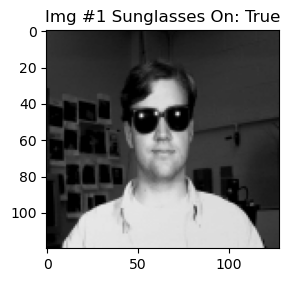

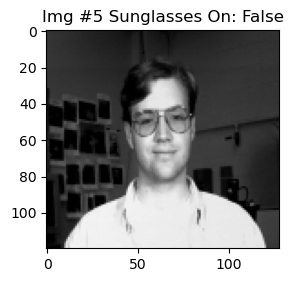

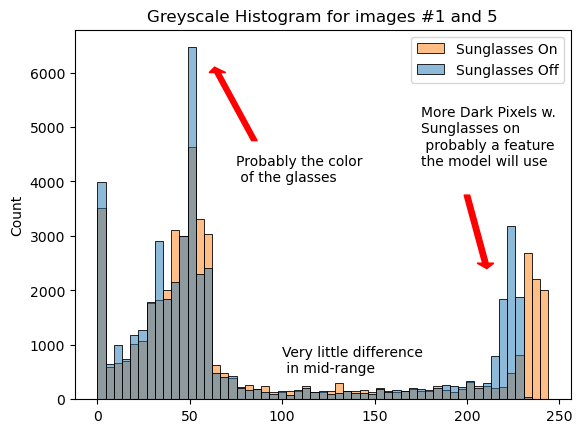

In [12]:
#Select a random image from the data set and inspect the format of the image data visually
X = df["pixels"]
y = df["sunglasses_on"]

def show_image(X, y, index, title=""):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(X[index].reshape(120, 128, 3), cmap='gray')
    plt.title(title + "Sunglasses On: " + str(bool(y[index])))
    plt.show()

print("Pixel Data information...")
print("image data dtype", X[0].dtype)
print("image data shape", X[0].shape)

#select two similar images one with sunglasses on/off
show_image(X, y, 1, "Img #1 ")
show_image(X, y, 5, "Img #5 ")

#Create a Pixel Histogram
hist =  seaborn.histplot([X[1], X[5]])
hist.set(title="Greyscale Histogram for images #1 and 5");
hist.legend(labels=["Sunglasses On", "Sunglasses Off"]);
hist.annotate("More Dark Pixels w.\nSunglasses on \n probably a feature \nthe model will use", xy = (175, 4300));
hist.arrow(200, 3750, 10, -1250, width=3, head_width=9, head_length=100, facecolor='r', edgecolor='r');

hist.annotate("Probably the color \n of the glasses", xy = (75, 4000));
hist.arrow(85, 4750, -20, 1250, width=3, head_width=9, head_length=100, facecolor='r', edgecolor='r');

hist.annotate("Very little difference \n in mid-range", xy = (100, 500));



### 5.) Modeling

Several models will be evaluated for accuracy and performance on this dataset. 

#### Models Chosen to Evaluate
I chose to evaluate four classification models total.

- K-Nearest Neighbors (KNN)
- Gaussian Naive Bayes (not discussed in the course)
- Support Vector Machine (SVM)
- Random Forest Ensemble

#### Methods to improve tuning, reduce over-fitting and evaluate performance
- Cross-validation and tuning is done only on the training data set, which is split 50% from test data to ensure the test data has not been seen by the model before (this will punish over-fitting). 
- In each model, I have used K-folds (K=5) cross-validation and GridSearchCV to automate parameter tuning.
- Scoring for GridSearch is done based on the accuracy metric. This dataset is balanced (50% of subjects wear sunglasses, 50% do not)
- To evaluate model speed vs. accuracy, I have timed the fit and prediction instructions on each model 


**Methods employed to improve performance**
- Test/train split to ensure test data passed to the model has not been seen before
- Cross-validation with k-folds = 5
- GridSearchCV for parameters / hyperparameters

**Citation for Heatmap Code**<br>
*DTSA5509 Supervised Learning, University of Colorado Boulder, Week 6 Programming Assignment. Retrieved November 23 2023*

In [75]:
# We'll use the same test/train split on all models to ensure comparability
# Note we are still splitting the data even though we use cross-validation to ensure
# the models are seeing truly new data. That is why we use a full 1/2 of the 

X = list(df["pixels"])
y = list(df["sunglasses_on"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50)

#Source: Modified from Week 6 homework support function code 
def plotSearchGrid(grid, param1_label, param2_label, vmin=0.2, vmax=0.92):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid[param1_label]), len(grid.param_grid[param2_label]))

    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)

    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=Normalize(vmin=vmin, vmax=vmax))
    
    #plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
    #        norm=MidpointNormalize(vmin=vmin, midpoint=midpoint))

    plt.xlabel(param1_label)
    plt.ylabel(param2_label)
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid[param2_label])), grid.param_grid[param2_label], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid[param1_label])), grid.param_grid[param1_label])
    plt.title('Validation accuracy')
    plt.show()

#### a.) K-Nearest Neighbors (KNN) Model 

KNN attempts to assess similarity between images based on a "distance" calculation. In this case, the number of different pixels from image-to-image. 

best params {'n_neighbors': 6, 'weights': 'distance'}


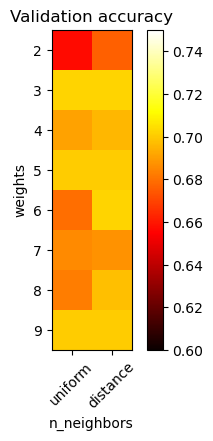

Training time = 0.003139607000775868 seconds
Prediction time = 0.11063461500089034 seconds
Accuracy Score: 0.7435897435897436

Confusion Matrix (Test Data):


,0,1
0,119,51
1,29,113



Confusion Matrix (Training Data):


,0,1
0,143,0
1,0,169


In [149]:
#We will use GridSearch cross validation to iterate over model parameters
parameters = {
    "n_neighbors" : np.asarray([i for i in range(2, 10)]), 
    "weights" : ["uniform", "distance"], 
}

#Here we'll do the Grid Search Cross-validation with K-folds = 5
clf_KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(clf_KNN, parameters, cv= 5, scoring="accuracy")
grid_KNN.fit(X, y)
print("best params", grid_KNN.best_params_)

plotSearchGrid(grid_KNN, "n_neighbors", "weights", vmin=0.60, vmax=0.75)

clf_KNN = KNeighborsClassifier(
        n_neighbors = grid_KNN.best_params_["n_neighbors"],
        weights = grid_KNN.best_params_["weights"]
)

start = timer()
clf_KNN.fit(X_train, y_train)
end = timer()
print(f"Training time = {end-start} seconds")
#clf = grid.best_estimator_

start = timer()
y_pred_test_KNN = clf_KNN.predict(X_test)
end = timer()

print(f"Prediction time = {end-start} seconds")
print("Accuracy Score:", accuracy_score(y_test, y_pred_test_KNN))

conf_matrix_KNN_test = confusion_matrix(y_test, y_pred_test_KNN)
conf_matrix_KNN_test = pd.DataFrame(conf_matrix_KNN_test)
print("\nConfusion Matrix (Test Data):")
display(HTML(conf_matrix_KNN_test.to_html()))

y_pred_train_KNN = clf_KNN.predict(X_train)
conf_matrix_KNN_train = confusion_matrix(y_train, y_pred_train_KNN)
conf_matrix_KNN_train = pd.DataFrame(conf_matrix_KNN_train)
print("\nConfusion Matrix (Training Data):")
display(HTML(conf_matrix_KNN_train.to_html()))



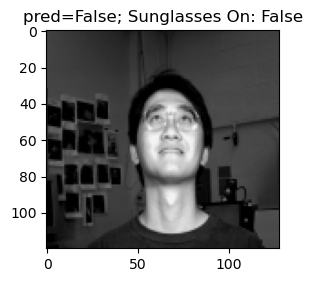

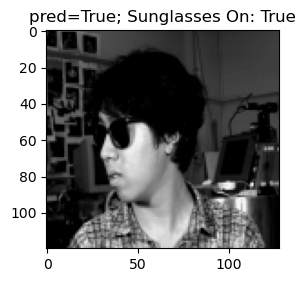

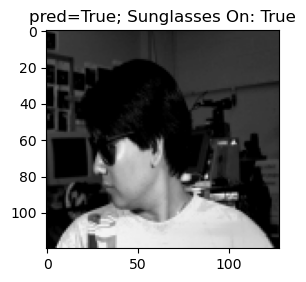

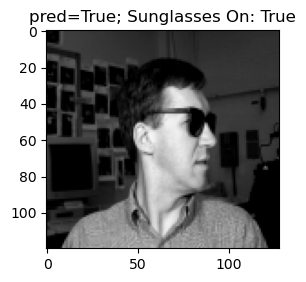

In [150]:

#spot check a few random images
for i in range(4):
    idx = random.randint(0, len(y_pred_test_KNN))
    show_image(X_test, y_test, idx, f"pred={bool(y_pred_test_KNN[idx])}; ")


#### b.) Support Vector Machine (SVM)

SVM model attempts to draw a hyperplane (with a soft boundary) in higher dimensions to separate the two classes. Note, I have tested different kernel types for the SVM classfier and determined polynomial was best suited. The SVM model takes a long time to train/iterate over, so eliminating this as a search parameter is preferable for cross-validation. 

In [89]:
#We will use GridSearch cross validation to iterate over model parameters
parameters = {
    "C" : np.logspace(start=-15, stop=-8, num=5, base = 2), 
    "gamma" : np.logspace(start=-6, stop=0, num=5, base = 2),
}

#Here we'll do the Grid Search Cross-validation with K-folds = 5
clf_SVC = SVC(kernel="poly")
grid_SVC = GridSearchCV(clf_SVC, parameters, cv= 5, scoring="accuracy")
grid_SVC.fit(X, y)


GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': array([3.05175781e-05, 1.02648488e-04, 3.45266983e-04, 1.16133507e-03,
       3.90625000e-03]),
                         'gamma': array([0.015625  , 0.04419417, 0.125     , 0.35355339, 1.        ])},
             scoring='accuracy')

Training time time = 1.491124320000381 seconds
Prediction time = 0.9798450990001584 seconds
Accuracy Score: 0.9230769230769231

Confusion Matrix (Test Data):


,0,1
0,153,17
1,7,135



Confusion Matrix (Training Data):


,0,1
0,143,0
1,0,169


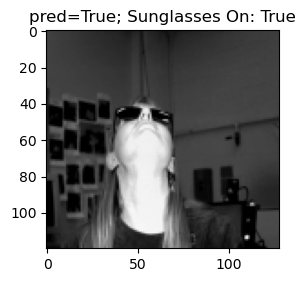

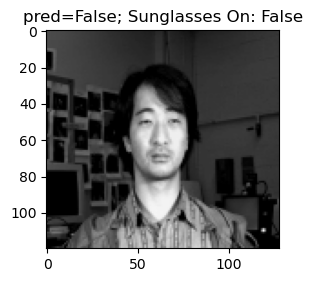

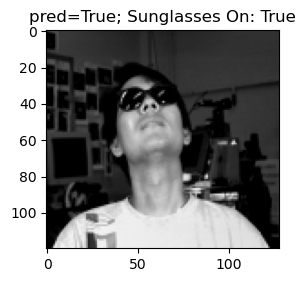

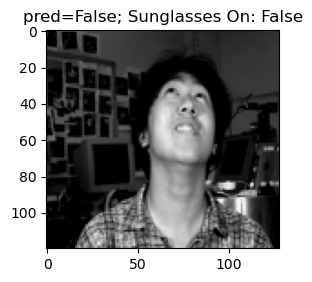

In [125]:

C = grid_SVC.best_params_["C"]
gamma = grid_SVC.best_params_["gamma"]
clf_SVC = SVC(C = C, gamma = gamma, kernel="poly")

start = timer()
clf_SVC.fit(X_train, y_train)
end = timer()
print(f"Training time time = {end-start} seconds")

start = timer()
y_pred_test_SVC = clf_SVC.predict(X_test)
end = timer()
print(f"Prediction time = {end-start} seconds")

print("Accuracy Score:", accuracy_score(y_test, y_pred_test_SVC))

conf_matrix_SVC_test = confusion_matrix(y_test, y_pred_test_SVC)
conf_matrix_SVC_test = pd.DataFrame(conf_matrix_SVC_test)
print("\nConfusion Matrix (Test Data):")
display(HTML(conf_matrix_SVC_test.to_html()))

y_pred_train_SVC = clf_SVC.predict(X_train)
conf_matrix_SVC_train = confusion_matrix(y_train, y_pred_train_SVC)
conf_matrix_SVC_train = pd.DataFrame(conf_matrix_SVC_train)
print("\nConfusion Matrix (Training Data):")
display(HTML(conf_matrix_SVC_train.to_html()))

#spot check a few random images
for i in range(4):
    idx = random.randint(0, len(y_pred))
    show_image(X_test, y_test, idx, f"pred={bool(y_pred_test_SVC[idx])}; ")

#### C.) Naive Bayes Classifier (Not covered in the course)

High level description of the Naive Bayes classiifer. 
[https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c)

best params {'var_smoothing': 0.8572439828530728}
Training time = 0.08929474500018841 seconds
Prediction time = 0.12945404299989605 seconds
Accuracy Score: 0.6378205128205128

Confusion Matrix (Test Data):


,0,1
0,101,69
1,44,98



Confusion Matrix (Training Data):


,0,1
0,105,38
1,43,126


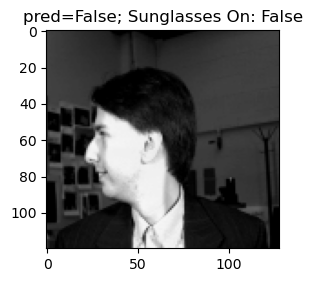

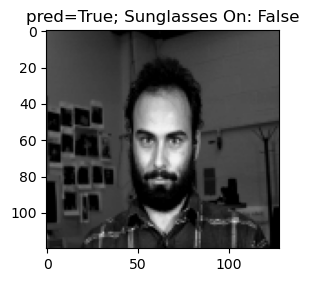

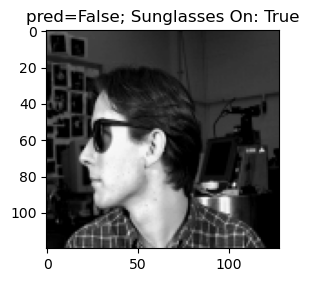

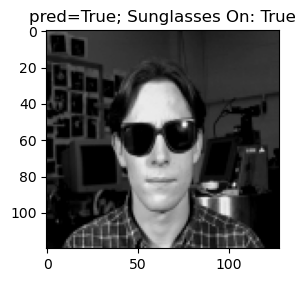

In [133]:
parameters = {
    "var_smoothing" : np.logspace(start=-2, stop=2, num=10, base=2)
}

clf_NB = GaussianNB()
grid_NB = GridSearchCV(clf_NB, parameters, cv= 5, scoring="accuracy")
grid_NB.fit(X, y)

print("best params", grid_NB.best_params_)

start = timer()
clf_NB.fit(X_train, y_train)
end = timer()
print(f"Training time = {end-start} seconds")

start = timer()
y_pred_NB_test = clf_NB.predict(X_test)
end = timer()
print(f"Prediction time = {end-start} seconds")

print("Accuracy Score:", accuracy_score(y_test, y_pred_NB_test))

conf_matrix_NB_test = confusion_matrix(y_test, y_pred_NB_test)
conf_matrix_NB_test = pd.DataFrame(conf_matrix_NB_test)
print("\nConfusion Matrix (Test Data):")
display(HTML(conf_matrix_NB_test.to_html()))

y_pred_NB_train = clf_NB.predict(X_train)
conf_matrix_NB_train = confusion_matrix(y_train, y_pred_NB_train)
conf_matrix_NB_train = pd.DataFrame(conf_matrix_NB_train)
print("\nConfusion Matrix (Training Data):")
display(HTML(conf_matrix_NB_train.to_html()))

#spot check a few random images
for i in range(4):
    idx = random.randint(0, len(y_pred))
    show_image(X_test, y_test, idx, f"pred={bool(y_pred_NB_test[idx])}; ")


#### d.) Random Forest Classifier 


In [118]:
parameters = {
    "n_estimators" : [50], 
    "max_depth" : [1, 5, 10, 15], 
    "min_samples_leaf" :  [1, 2, 4] 
}

clf_RF = RandomForestClassifier()
grid_RF = GridSearchCV(clf_RF, parameters, cv= 5, scoring="accuracy")
grid_RF.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4], 'n_estimators': [50]},
             scoring='accuracy')

best params {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 50}
Training time = 1.5541253510000388 seconds
Prediction time = 0.01827658500042162 seconds
Accuracy Score: 0.8557692307692307

Confusion Matrix (Test Data):


,0,1
0,133,37
1,8,134



Confusion Matrix (Training Data):


,0,1
0,105,38
1,43,126


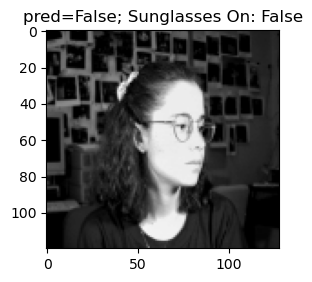

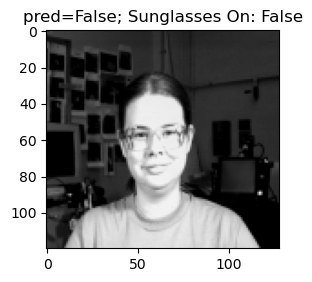

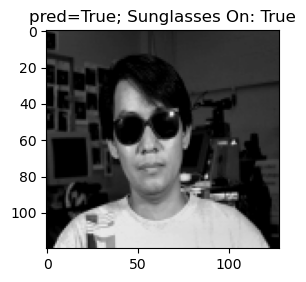

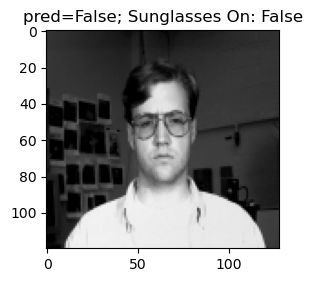

In [132]:
print("best params", grid_RF.best_params_)

start = timer()
clf_RF.fit(X_train, y_train)
end = timer()
print(f"Training time = {end-start} seconds")

start = timer()
y_pred_RF_test = clf_RF.predict(X_test)
end = timer()
print(f"Prediction time = {end-start} seconds")

print("Accuracy Score:", accuracy_score(y_test, y_pred_RF_test))


conf_matrix_RF_test = confusion_matrix(y_test, y_pred_RF_test)
conf_matrix_RF_test = pd.DataFrame(conf_matrix_RF_test)
print("\nConfusion Matrix (Test Data):")
display(HTML(conf_matrix_RF_test.to_html()))

y_pred_RF_train = clf_NB.predict(X_train)
conf_matrix_NB_train = confusion_matrix(y_train, y_pred_RF_train)
conf_matrix_NB_train = pd.DataFrame(conf_matrix_NB_train)
print("\nConfusion Matrix (Training Data):")
display(HTML(conf_matrix_NB_train.to_html()))

#spot check a few random images
for i in range(4):
    idx = random.randint(0, len(y_pred))
    show_image(X_test, y_test, idx, f"pred={bool(y_pred_RF_test[idx])}; ")

### 6.) Results and Analysis

#### a.) Summary Table


| Rank | Model             | Test Accuracy | Training Time (s) | Test Time (s) | 
| :---- | :---------------- | :------: | ----: | ----: |
| 1 | SVM               |  0.9231    | 1.4911| 0.9798 |
| 2 | Random Forest     |  0.8558    | 1.5423 | 0.0189 |
| 3 | KNN               |  0.7436   | 0.0033 | 0.1073 |
| 4 | Naive Bayes       |  0.6378  | 0.08925 | 0.1275 |

#### b.) Discussion 

**Final Model**<br>
The support vector machine model is chosen as the final classifier for this project due to its superior accuracy. It was also the slowest model evaluated, and so this choice could be affected by the size of the data set, and the need for realtime decision making. 


**Training and Tuning**<br>
For all of the models chosen, I first ran some manual tests to get a better idea of the best range for model parameters/hyperparameters. Then I used an automated GridSearch Cross validator to iterate over these ranges for fine-tuning. 

**Metrics**<br>
In this case, the data set is well balanced - e.g. 50% of the images have sunglasses on, and 50% have them off. So i have chosen to use **prediction accuracy** as the scoring metric. In all cases, I have also printed a confusion matrix for the test data as well as the train data to be able to inspect the relative rates of false positive/false negative. 


**Accuracy and Performance**<br>
It is somewhat expected that the SVM model performs the best as it is the most complex model chosen. In the summary table we see a clear inverse correlation between training/test time and accuracy. The worst performing models, KNN and Naive Bayes are much simpler, and test/train in 2 orders of magnitude less time on average. 

All of the models were more likely to predict a false-positive than a false-negative. It is also interesting to see that the Naive Bayes and Random forest models did not have much better accuracy for training than test data predicitons. 

Below I inspect a couple of false negatives and positives visually, using SVM as the top model. It is seen that the direction of the face is challenging for the classifier to manage. Also subjects with darker eyes were more likely to be false positive. 



In [152]:
clf = clf_SVC
y_pred_test = clf.predict(X_test)

false_positives = []
false_negatives = []

for i in range(len(y_test)):
    pred = y_pred_test[i]
    act = y_test[i]

    if (pred != act) and (pred==False):
        false_negatives.append(i)

    if (pred != act) and (pred==True):
            false_positives.append(i)


#### False Positives 

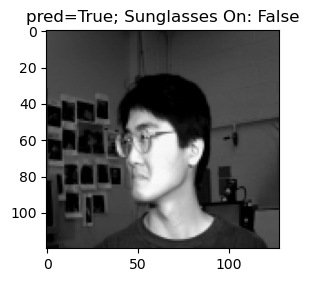

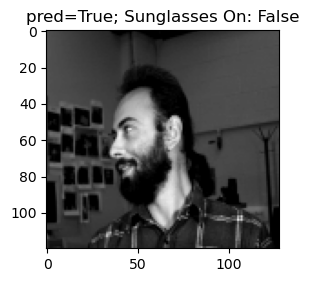

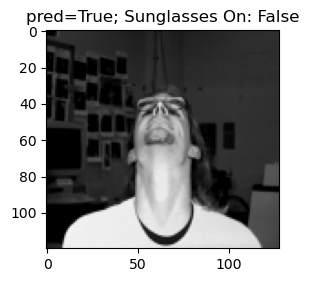

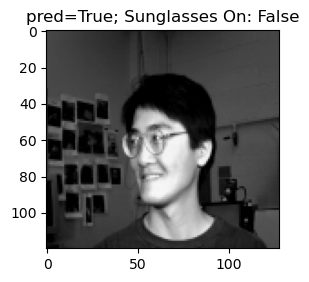

In [153]:
for i in range(4):
    idx = false_positives[i]
    show_image(X_test, y_test, idx, f"pred={bool(y_pred_test[idx])}; ")

#### False Negatives

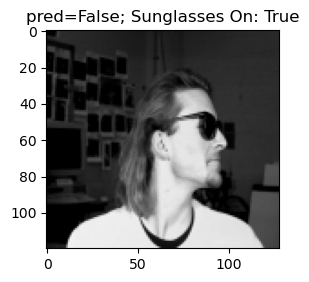

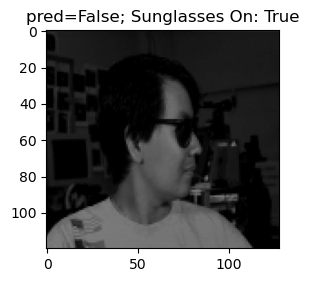

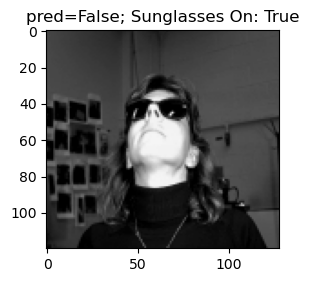

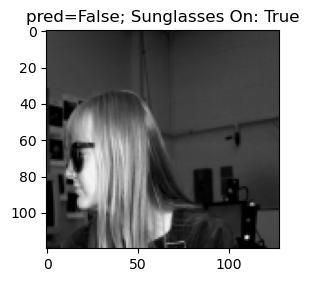

In [154]:

for i in range(4):
    idx = false_negatives[i]
    show_image(X_test, y_test, idx, f"pred={bool(y_pred_test[idx])}; ")

### 7.) Conclusion 

**Key Takeaways**<br>
This project provided a good hands-on opportunity to use the supervised learning techniques described in the course to perform a real-world classification task. Image classifiers are increasingly being integrated into applications we use daily. I learned more details in particular about using the sklearn libraries to perform analysis on large data sets, of image data as opposed to neatly arranged test data as in the homeworks. 

**Challenges Faced**<br>
Cleaning, indexing, and loading the data was particularly relevant to this project, as that part took the most time. 

Some interesting challenges faced in this project were around EDA and debugging. In particular most of the EDA techniques discussed in the course were applicable to regression problems, or easily interpretable data points, in lower dimensions. It was  more challenging to understand intuitively. Also some methods explored to reject features and simplify models were not possible with image data. This project was also my first time setting up a local jupyter notebook (normally I stick with a text editor).

**Suggestions to Improve**<br>
To improve the performance further, I would recommend to:
- Investigate more efficient models than SVM, trade-off with accuracy if needed
- Use a larger training data set
- Investigate the accuracy hit involved in using lower resolution images to improve speed
- Perform a more exhaustive parameter grid-search on a higher performance computer
- Include color photographs - presumably color would differentiate the sunglasses more vs. dark spots in greyscale images. 

